In [ ]:
import ollama

response = ollama.generate(model='llama3.2',
prompt='what is a qubit?')
print(response['response'])

In [ ]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model='llama3.2', temperature=3.2)
llm.invoke("what is a qubit?")

AIMessage(content='A qubit (quantum bit) is the fundamental unit of quantum information in quantum computing. It\'s the basic building block for all quantum computers.\n\nIn classical computing, bits are used to store and process information. A bit can have only one value: 0 or 1. But, because light can exist in multiple states at the same time (known as a superposition), quantum mechanics introduces qubits that can represent both 0 and 1 simultaneously.\n\nQubits are incredibly sensitive to their environment, making them highly prone to decoherence (loss of coherence due to interactions with other particles or radiation). This fragility is what allows for exotic properties like:\n\n1. **Superposition**: A qubit can exist in multiple states (0 and 1) at the same time.\n2. **Entanglement**: Qubits can become "linked" together, allowing their properties to be correlated even when separated by large distances.\n3. **Quantum entanglement swapping**: Entangled particles can be linked across


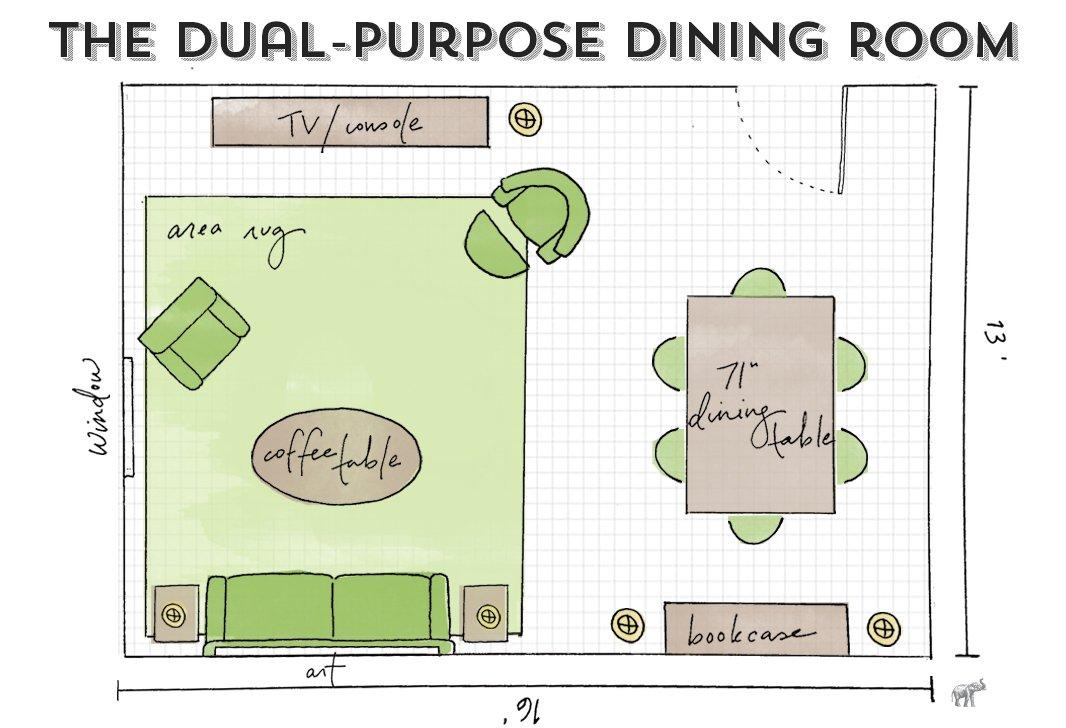

In [24]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    """
    Disply base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


file_path = "./layout.jpg"
pil_image = Image.open(file_path)

image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

In [18]:
from torch import device
if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

In [25]:
from langchain_core.tools import tool
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np
import torch

def sam2():
    model_name = "facebook/sam2-hiera-small"
    device = "cuda"
    predictor = SAM2ImagePredictor.from_pretrained(
            model_name, torch_dtype=torch.float16, trust_remote_code=True, device=device
        )
    image = Image.open("layout.jpg")
    predictor.set_image(image)
    input_box = np.zeros((4,4))
    masks, scores, _ = predictor.predict(point_coords=None, box=input_box[:, None], multimask_output=False)
    return masks.astype(bool)
masks = sam2()


In [28]:
import matplotlib.pyplot as plt
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

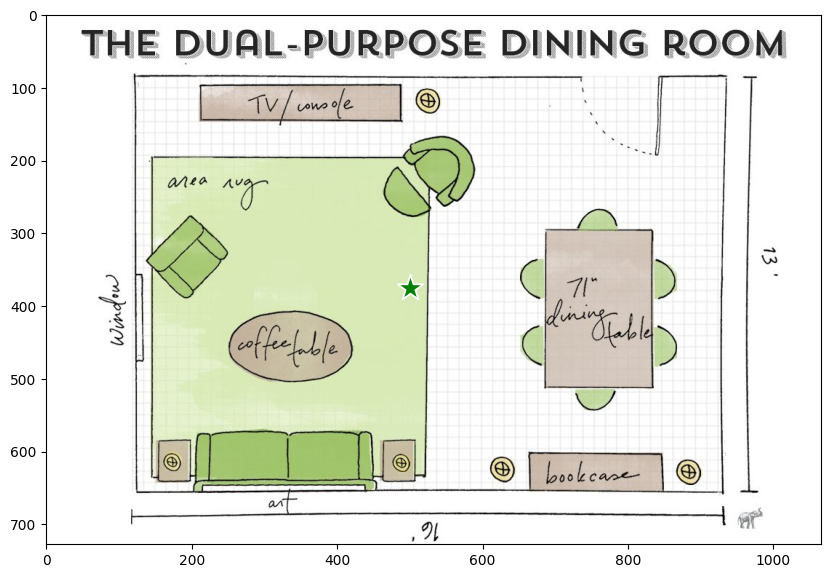

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [ ]:
image = Image.open("layout.jpg")
image = np.array(image.convert("RGB"))
# show_masks(image, masks, [1.0], borders=True)
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.axis('on')
# plt.show()

input_point = np.array([[500, 375]])
input_label = np.array([1])
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

model_name = "facebook/sam2-hiera-small"
device = "cuda"
predictor = SAM2ImagePredictor.from_pretrained(
        model_name, torch_dtype=torch.float16, trust_remote_code=True, device=device
    )
predictor.set_image(image)
# input_box = np.zeros((4,4))
# masks, scores, _ = predictor.predict(point_coords=None, box=input_box[:, None], multimask_output=False)
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

In [41]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

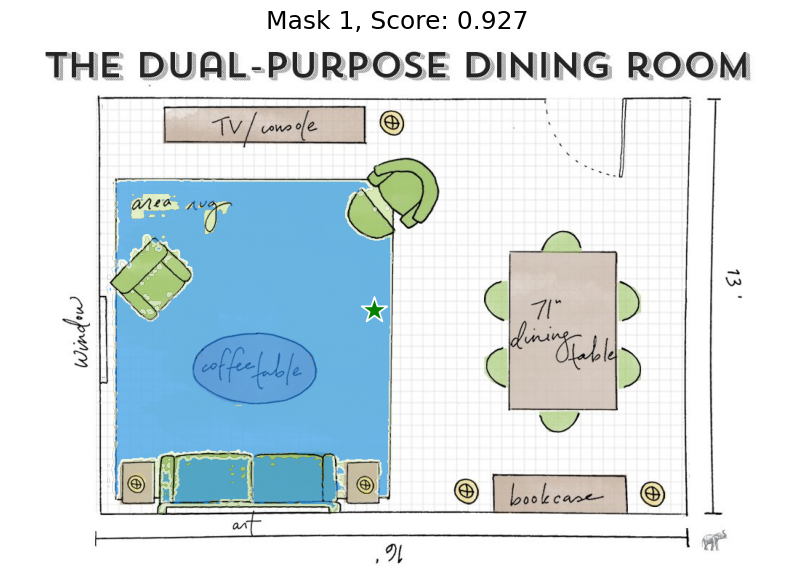

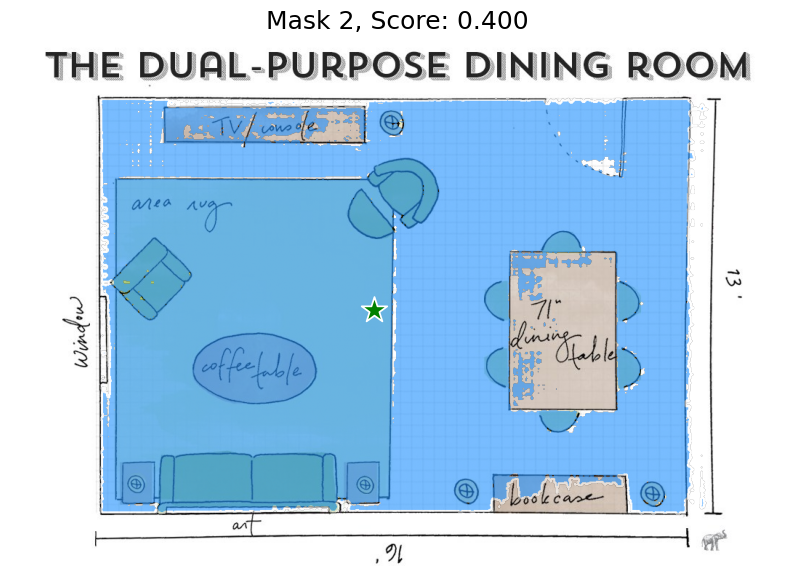

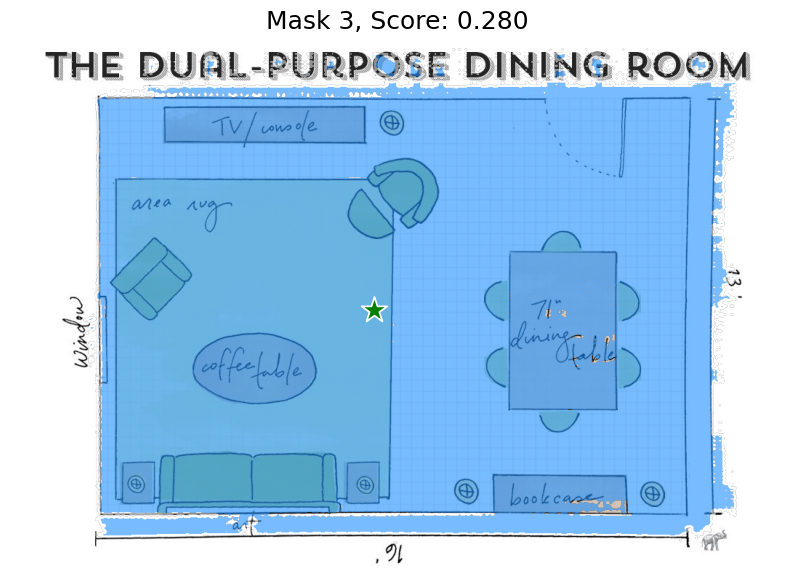

In [43]:
masks.shape  # (number_of_masks) x H x W
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

In [26]:
print(masks)

[[[[ True  True  True ... False False False]
   [ True  True  True ... False False False]
   [ True  True  True ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]]


 [[[ True  True  True ... False False False]
   [ True  True  True ... False False False]
   [ True  True  True ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]]


 [[[ True  True  True ... False False False]
   [ True  True  True ... False False False]
   [ True  True  True ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]]


 [[[ True  True  True ... False False False]
   [ True  True  True ... False False False]
   [ True  True  True ... False False False]
   ...
   [False False

In [25]:
from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2-vision", temperature=0)


def prompt_func(data):
    text = data["text"]
    image = data["image"]

    image_part = {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{image}",
    }

    content_parts = []

    text_part = {"type": "text", "text": text}

    content_parts.append(image_part)
    content_parts.append(text_part)

    return [HumanMessage(content=content_parts)]


from langchain_core.output_parsers import StrOutputParser

chain = prompt_func | llm | StrOutputParser()

query_chain = chain.invoke(
    {"text": "You are an expert in layout design. Give suggestions for how we can improve the layout of this layout plan such that everything is organized and arranged corerctly. Write them in bullet points.", "image": image_b64}
)

print(query_chain)

**Layout Plan Suggestions**

To enhance the functionality and aesthetics of your dining room, consider the following adjustments:

*   **Rearrange Furniture**: Move the coffee table to a more central location, allowing for easier access from both sides of the sofa.
*   **Optimize Sofa Placement**: Position the sofa perpendicular to the window, creating a cozy reading nook while maintaining a clear path through the room.
*   **Enhance TV Viewing Experience**: Place the TV on a wall opposite the sofa, ensuring an unobstructed view for all occupants.
*   **Improve Traffic Flow**: Rearrange furniture to create a more open and inviting space, facilitating movement throughout the room.
*   **Maximize Storage**: Incorporate additional storage solutions, such as bookshelves or cabinets, to maintain a clutter-free environment.

By implementing these suggestions, you can transform your dining room into a functional and visually appealing space that meets your needs.


In [22]:
import dspy

lm = dspy.OllamaLocal(model="llama3.2")

/home/chenyenru/anaconda3/envs/eyeq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
dspy.configure(lm=lm)
lm("Say this is a test!", temperature=0.7)  

['Test confirmed! How can I assist you today?']